In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

In [54]:
h_start = 0.1
h_min = 0.005
a = np.sqrt(2)
noise_std = 0.2
outlier = 5.0

n_points = 2000
eps = 1e-3

In [50]:
x_syn = np.linspace(eps, 1.0, n_points)
y_clean_syn = (1 + 0.5 * np.sin(4 * np.pi * x_syn)) * np.sin(2 * np.pi * (6 * x_syn + 12 * x_syn**3))

np.random.seed(42)

# 10% Outliers
is_outlier = np.random.rand(n_points) < 0.1
noise = np.zeros(n_points)

noise[~is_outlier] = np.random.normal(scale=noise_std, size=np.sum(~is_outlier))

outliers = np.random.exponential(scale=noise_std * outlier, size=np.sum(is_outlier))
outliers *= np.random.choice([-1, 1], size=len(outliers))
noise[is_outlier] = outliers


y_noisy_syn = y_clean_syn + noise

components_syn = []
residuals_list_syn = []
current_residuals_syn = y_noisy_syn.copy()

components_clean_syn = []
residuals_list_clean_syn = []
current_residuals_clean = y_clean_syn.copy()

In [51]:
h_curr = h_start
if len(x_syn) > 1:
    dx = (x_syn[-1] - x_syn[0]) / (len(x_syn) - 1)
else:
    dx = 1.0

while h_curr >= h_min:
    n_window = int(np.ceil(h_curr / dx))
    if n_window < 1: n_window = 1
    
    k_x = np.arange(-n_window, n_window + 1) * dx
    
    if h_curr == 0:
        weights = np.zeros_like(k_x)
        weights[len(weights)//2] = 1
    else:
        weights = 0.75 * (1 - (k_x / h_curr)**2)
        weights[weights < 0] = 0
        
    if weights.sum() > 0:
        weights = weights / weights.sum()

    denominator = fftconvolve(np.ones_like(current_residuals_syn), weights, mode='same')
    denominator_safe = denominator + 1e-10

    numerator_syn = fftconvolve(current_residuals_syn, weights, mode='same')
    y_smooth_syn = numerator_syn / denominator_safe
    
    components_syn.append(y_smooth_syn)
    current_residuals_syn = current_residuals_syn - y_smooth_syn
    residuals_list_syn.append(current_residuals_syn.copy())

    numerator_clean = fftconvolve(current_residuals_clean, weights, mode='same')
    y_smooth_clean = numerator_clean / denominator_safe
    
    components_clean_syn.append(y_smooth_clean)
    current_residuals_clean = current_residuals_clean - y_smooth_clean
    residuals_list_clean_syn.append(current_residuals_clean.copy())

    h_curr /= a

  0%|          | 0/9 [00:00<?, ?it/s]

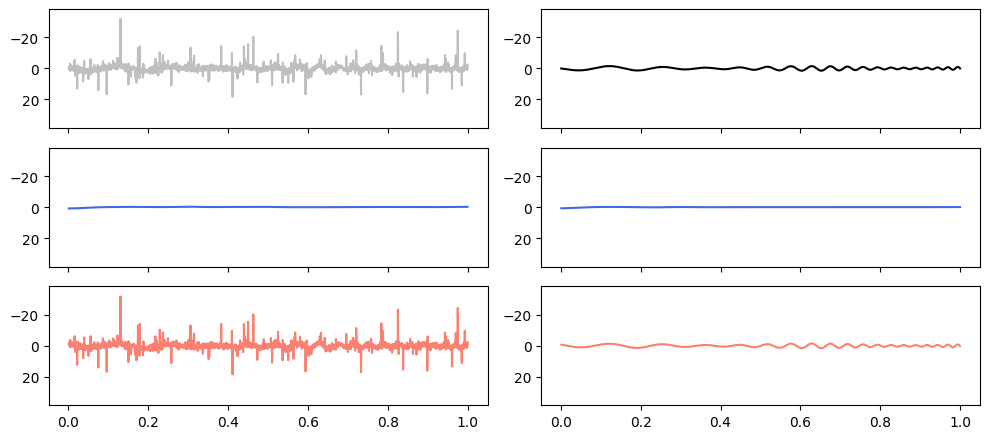

 11%|█         | 1/9 [00:00<00:01,  7.04it/s]

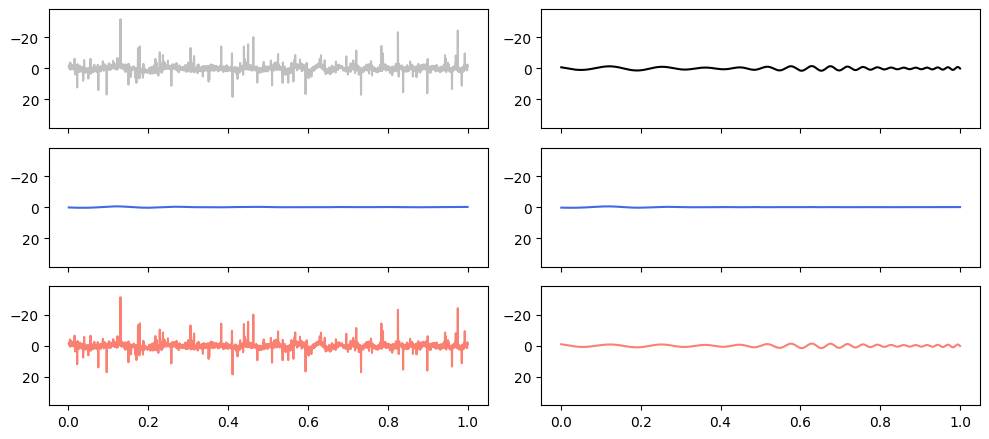

 22%|██▏       | 2/9 [00:00<00:00,  7.55it/s]

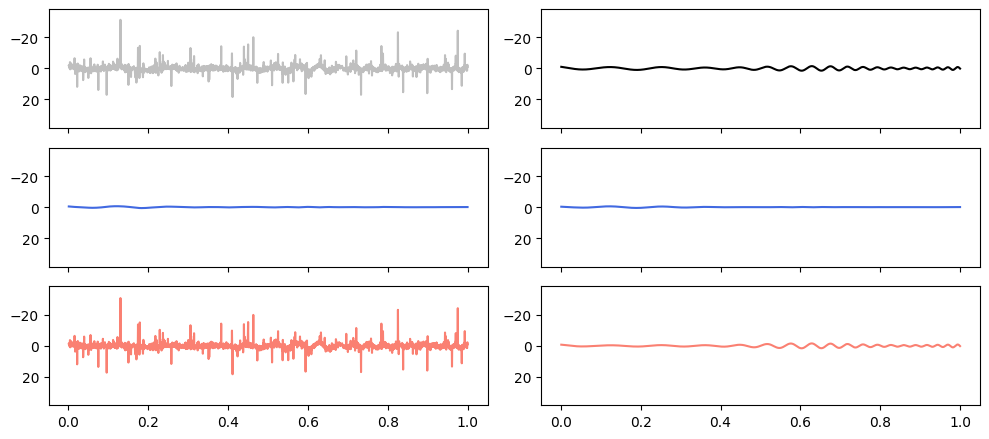

 33%|███▎      | 3/9 [00:00<00:00,  7.81it/s]

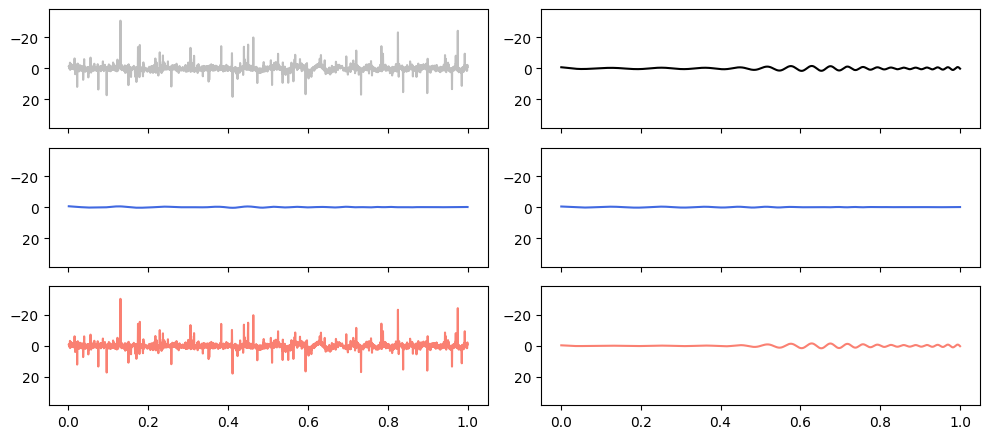

 44%|████▍     | 4/9 [00:00<00:00,  7.85it/s]

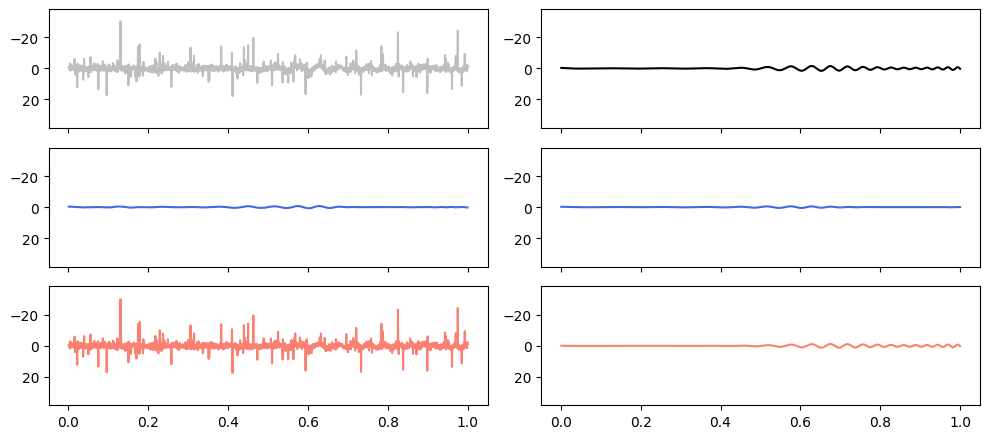

 56%|█████▌    | 5/9 [00:00<00:00,  6.82it/s]

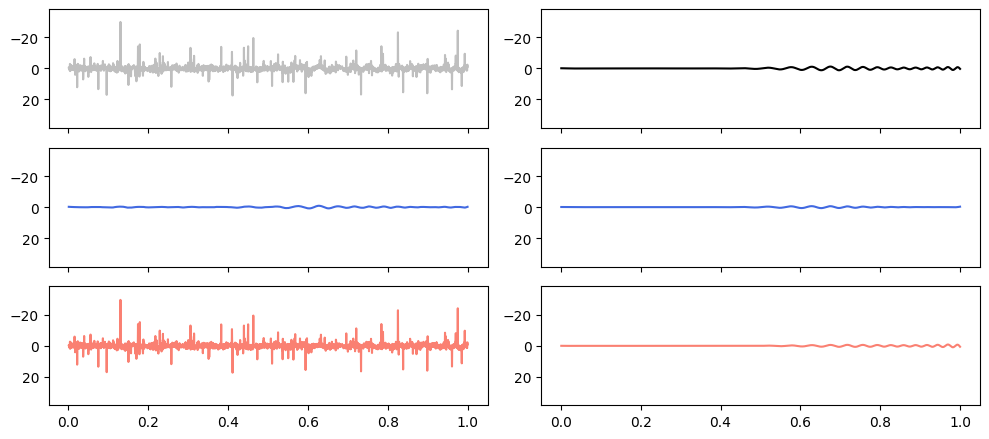

 67%|██████▋   | 6/9 [00:00<00:00,  7.17it/s]

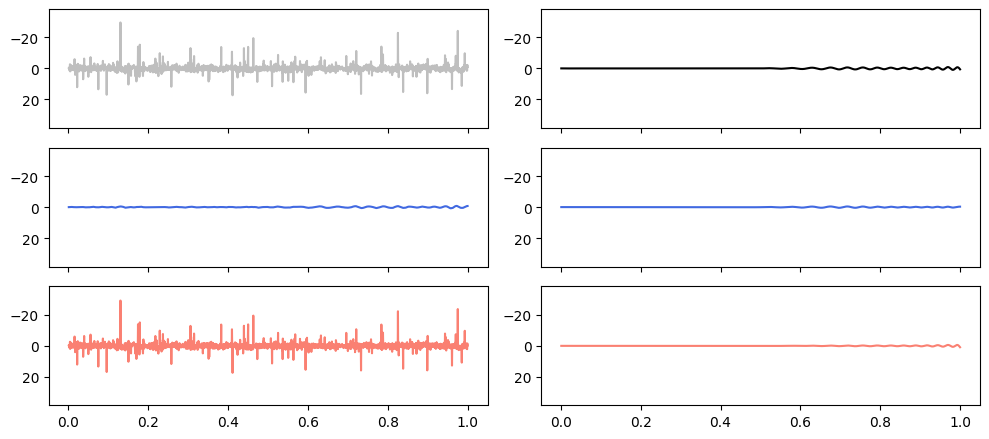

 78%|███████▊  | 7/9 [00:00<00:00,  7.40it/s]

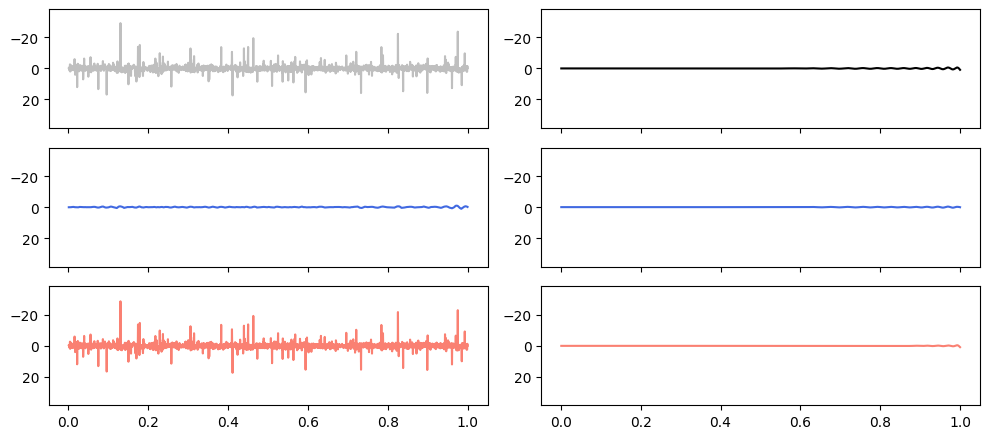

 89%|████████▉ | 8/9 [00:01<00:00,  7.50it/s]

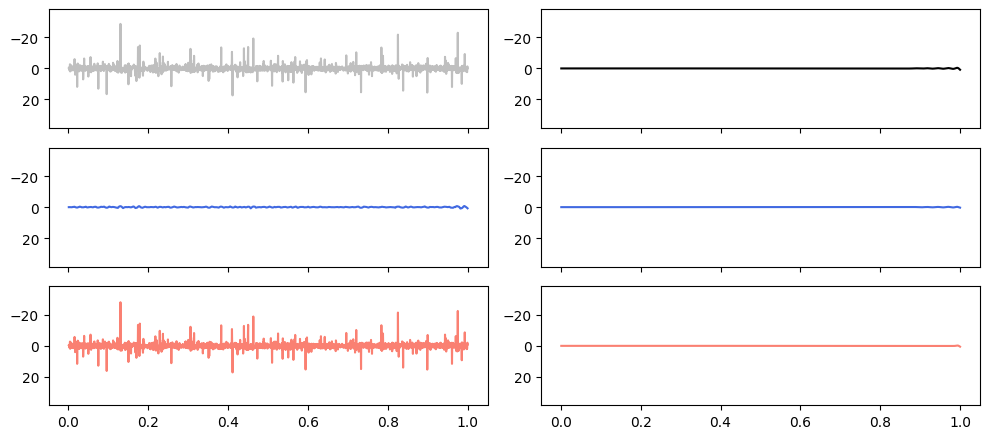

100%|██████████| 9/9 [00:01<00:00,  7.49it/s]


In [52]:
valid_data = y_noisy_syn[~np.isnan(y_noisy_syn)]
y_min = max(abs(np.min(valid_data)), abs(np.max(valid_data)))
y_max = -max(abs(np.min(valid_data)), abs(np.max(valid_data)))
y_range = y_max - y_min
if y_range == 0: y_range = 1.0
ylim_lower = y_min - 0.1 * y_range
ylim_upper = y_max + 0.1 * y_range

for i in tqdm(range(len(components_syn))):
    # print(f"Iteration {i + 1}")
    if i == 0:
        curr_input_noisy = y_noisy_syn
        curr_input_clean = y_clean_syn
    else:
        curr_input_noisy = residuals_list_syn[i-1]
        curr_input_clean = residuals_list_clean_syn[i-1]

    fig, axes = plt.subplots(3, 2, figsize=(10, 4.5), sharex=True)

    axes[0, 0].plot(x_syn, curr_input_noisy, color='gray', linewidth=1.5, alpha=0.5)
    axes[1, 0].plot(x_syn, components_syn[i], color='royalblue', linestyle='-', linewidth=1.5)
    axes[2, 0].plot(x_syn, residuals_list_syn[i], color='salmon', linestyle='-', linewidth=1.5)

    axes[0, 1].plot(x_syn, curr_input_clean, color='black', linestyle='-', linewidth=1.5)
    axes[1, 1].plot(x_syn, components_clean_syn[i], color='royalblue', linestyle='-', linewidth=1.5)
    axes[2, 1].plot(x_syn, residuals_list_clean_syn[i], color='salmon', linestyle='-', linewidth=1.5)

    for ax_row in axes:
        for ax in ax_row:
            ax.set_ylim(ylim_lower, ylim_upper)
            
    plt.tight_layout()
    plt.show()

Simulating Noise: 100%|██████████| 10/10 [00:00<00:00, 10.23it/s]


,0.00,0.22,0.44,0.67,0.89,1.11,1.33,1.56,1.78,2.00
0,0.0,0.0009,0.0039,0.0084,0.0157,0.0259,0.0328,0.0424,0.0628,0.0781
1,0.0,0.0002,0.0008,0.0018,0.0033,0.0059,0.0081,0.0101,0.0131,0.0176
2,0.0,0.0003,0.0010,0.0024,0.0042,0.0072,0.0101,0.0124,0.0164,0.0231
3,0.0,0.0004,0.0015,0.0036,0.0064,0.0099,0.0145,0.0182,0.0229,0.0317
4,0.0,0.0006,0.0022,0.0050,0.0089,0.0140,0.0200,0.0247,0.0320,0.0444
5,0.0,0.0008,0.0031,0.0069,0.0127,0.0197,0.0277,0.0360,0.0468,0.0647
6,0.0,0.0011,0.0044,0.0099,0.0174,0.0283,0.0388,0.0528,0.0681,0.0908
7,0.0,0.0016,0.0062,0.0137,0.0246,0.0405,0.0550,0.0739,0.0981,0.1279
8,0.0,0.0022,0.0087,0.0193,0.0345,0.0568,0.0775,0.1046,0.1358,0.1779


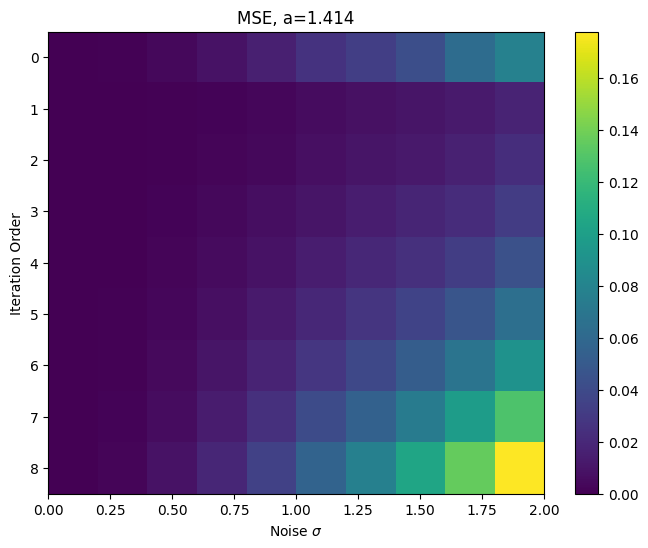

In [55]:
B = 100
sigma_values = np.linspace(0, 2, 10)

components_clean_ref = []
current_residuals_clean_ref = y_clean_syn.copy()
h_curr = h_start

while h_curr >= h_min:
    n_window = int(np.ceil(h_curr / dx))
    if n_window < 1: n_window = 1
    
    k_x = np.arange(-n_window, n_window + 1) * dx
    
    if h_curr == 0:
        weights = np.zeros_like(k_x)
        weights[len(weights)//2] = 1
    else:
        weights = 0.75 * (1 - (k_x / h_curr)**2)
        weights[weights < 0] = 0
        
    if weights.sum() > 0:
        weights = weights / weights.sum()

    denominator = fftconvolve(np.ones_like(current_residuals_clean_ref), weights, mode='same')
    denominator_safe = denominator + 1e-10
    numerator = fftconvolve(current_residuals_clean_ref, weights, mode='same')
    y_smooth = numerator / denominator_safe
    
    components_clean_ref.append(y_smooth)
    current_residuals_clean_ref = current_residuals_clean_ref - y_smooth
    h_curr /= a

n_iterations = len(components_clean_ref)
sse_results = np.zeros((n_iterations, len(sigma_values)))
for j, sigma_val in enumerate(tqdm(sigma_values, desc="Simulating Noise")):
    for b in range(B):
        np.random.seed(b + j * B) 
        
        is_outlier = np.random.rand(n_points) < 0.1
        noise_b = np.zeros(n_points)
        
        if sigma_val > 0:
            noise_b[~is_outlier] = np.random.normal(scale=sigma_val, size=np.sum(~is_outlier))
            
            outliers_b = np.random.exponential(scale=sigma_val * outlier, size=np.sum(is_outlier))
            outliers_b *= np.random.choice([-1, 1], size=len(outliers_b))
            noise_b[is_outlier] = outliers_b
        
        y_noisy_b = y_clean_syn + noise_b
        
        components_noisy_b = []
        current_residuals_noisy_b = y_noisy_b.copy()
        h_curr_b = h_start
        
        while h_curr_b >= h_min:
            n_window = int(np.ceil(h_curr_b / dx))
            if n_window < 1: n_window = 1
            
            k_x = np.arange(-n_window, n_window + 1) * dx
            
            if h_curr_b == 0:
                weights = np.zeros_like(k_x)
                weights[len(weights)//2] = 1
            else:
                weights = 0.75 * (1 - (k_x / h_curr_b)**2)
                weights[weights < 0] = 0
                
            if weights.sum() > 0:
                weights = weights / weights.sum()

            denominator = fftconvolve(np.ones_like(current_residuals_noisy_b), weights, mode='same')
            denominator_safe = denominator + 1e-10
            numerator = fftconvolve(current_residuals_noisy_b, weights, mode='same')
            y_smooth = numerator / denominator_safe
            
            components_noisy_b.append(y_smooth)
            current_residuals_noisy_b = current_residuals_noisy_b - y_smooth
            h_curr_b /= a
        
        n_comps = min(len(components_clean_ref), len(components_noisy_b))
        
        for k in range(n_comps):
            diff = components_noisy_b[k] - components_clean_ref[k]
            mse_k = np.mean(diff**2)
            sse_results[k, j] += mse_k
            
    sse_results[:, j] /= B


df_sse = pd.DataFrame(
    sse_results, 
    index=[f"{i}" for i in range(n_iterations)],
    columns=[f"{s:.2f}" for s in sigma_values]
)
display(df_sse.round(4))


plt.figure(figsize=(8, 6))
plt.imshow(sse_results, aspect='auto', cmap='viridis', 
            extent=[sigma_values[0], sigma_values[-1], n_iterations - 0.5, -0.5])
plt.colorbar()
plt.ylabel('Iteration Order')
plt.xlabel(r'Noise $\sigma$')
plt.title(f'MSE, a={a:.3f}')
plt.yticks(np.arange(n_iterations))
plt.show()